In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [44]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
reduced_data = data.head(1000)
print(reduced_data.shape)
reduced_data.fillna("",inplace=True)

(1000, 2)


D:\Systemp\ipykernel_10916\179636859.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data.fillna("",inplace=True)


### Let's divide the training and test set into two partitions

In [36]:
from sklearn.model_selection import train_test_split
X = data.drop('label', axis=1)
y = data['label']
X_train, X_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Preprocessing

In [37]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [55]:
class HTMLPreprocessor:
    """
    A class to handle all html preprocessing steps
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.inline_style_regex_pattern = r'\s*style=(\'|\").*(\'|\")\s*'
        self.inline_script_regex_pattern = r'\s+<script.*>.*<\/script>\s*'
        self.html_comments_regex_pattern = r'\s*<!--.*-->\s*'
        self.html_tags_regex_pattern = r'<[^>]+>'
        self.special_char_regex_pattern = r"[^A-Za-z\s]"
        self.digits_regex_pattern = r"\d+"
        self.single_char_regex_pattern = r'\b[A-Za-z]\b'
        self.start_char_regex_pattern = r'^[A-Za-z]\b'
        self.preffix_b_regex_pattern = r"^b['\"]?"
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_html_text(self, text):
        text = text.lower()
        # Remove inline style
        text = re.sub(self.inline_script_regex_pattern, '', text)
        # remove script html
        text = re.sub(self.inline_script_regex_pattern, '', text)
        # Remove html comments
        text = re.sub(self.html_comments_regex_pattern, '', text)
        # Remove extra whitespace
        text = re.sub(self.html_comments_regex_pattern, '', text) 
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def clean_rest(self, text):
        text = re.sub(self.special_char_regex_pattern, '', text)
        text = re.sub(self.digits_regex_pattern, '', text)
        text = re.sub(self.single_char_regex_pattern, '', text)
        text = re.sub(self.start_char_regex_pattern, '', text)
        text = re.sub(self.preffix_b_regex_pattern, '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = text.lower()
        return text

    def remove_stopwords(self, text):
        """Remove common stopwords using regex word boundaries"""
        # Create pattern with word boundaries for exact matches
        pattern = r'\b(' + '|'.join(self.stop_words) + r')\b'
        text = re.sub(pattern, '', text)
        # Clean up extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def lemmatize_text(self, text):
        """Apply lemmatization with regex tokenization"""
        # Use regex to extract words
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.lemmatizer.lemmatize(w) for w in words])

html_processor = HTMLPreprocessor()
data['preprocessed_text'] = data['text'].apply(html_processor.clean_html_text)

- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [56]:
data['preprocessed_text'] = data['preprocessed_text'].apply(html_processor.clean_rest)

## Now let's work on removing stopwords
Remove the stopwords.

In [57]:
data['preprocessed_text'] = data['preprocessed_text'].apply(html_processor.remove_stopwords)

## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [58]:
data['preprocessed_text'] = data['preprocessed_text'].apply(html_processor.lemmatize_text)

## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

Text(0.5, 0, 'Frequency')

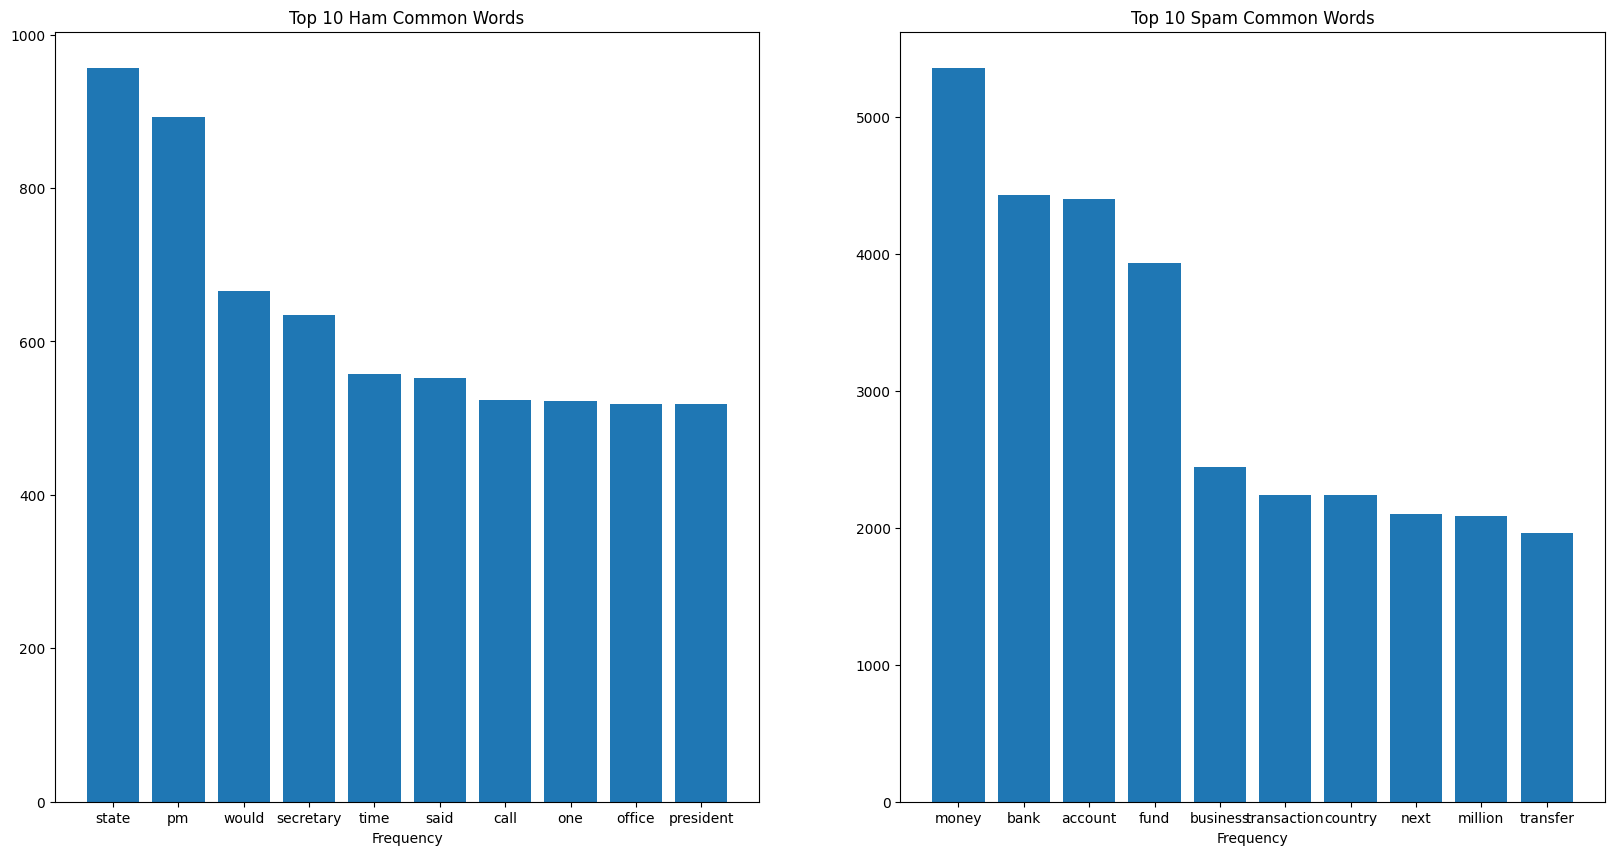

In [59]:
from collections import Counter

ham_messages = data[data["label"] == 0]["preprocessed_text"]
spam_messages = data[data["label"] == 1]["preprocessed_text"]

def tokenize(text):
    return re.findall(r"[a-zA-Z']+", text.lower())

ham_tokens = []
for msg in ham_messages:
    ham_tokens.extend(tokenize(msg))

spam_tokens = []
for msg in spam_messages:
    spam_tokens.extend(tokenize(msg))

ham_word_freq = Counter(ham_tokens)
spam_word_freq = Counter(spam_tokens)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ham_top_words = dict(ham_word_freq.most_common(10))
axes[0].bar(list(ham_top_words.keys()), list(ham_top_words.values()))
axes[0].set_title('Top 10 Ham Common Words')
axes[0].set_xlabel('Frequency')

spam_top_words = dict(spam_word_freq.most_common(10))
axes[1].bar(list(spam_top_words.keys()), list(spam_top_words.values()))
axes[1].set_title('Top 10 Spam Common Words')
axes[1].set_xlabel('Frequency')

## Extra features

In [60]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data['money_mark'] = data['preprocessed_text'].str.contains(money_simbol_list)*1
data['suspicious_words'] = data['preprocessed_text'].str.contains(suspicious_words)*1
data['text_len'] = data['preprocessed_text'].apply(lambda x: len(x)) 

""" data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x))  """

data.head()

,text,label,preprocessed_text,money_mark,suspicious_words,text_len
0,dear sir strictly private business proposal mi...,1,dear sir strictly private business proposal mi...,1,1,1498
1,,0,,0,0,0
2,noracheryl emailed dozen memo haiti weekend pl...,0,noracheryl emailed dozen memo haiti weekend pl...,0,0,110
3,dear sirfmadamc know proposal might surprise e...,1,dear sirfmadamc know proposal might surprise e...,1,1,1380
4,fyi,0,fyi,0,0,3


## How would work the Bag of Words with Count Vectorizer concept?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vect = CountVectorizer(max_features=1000)

# fit creates one entry for each different word seen
X = bow_vect.fit_transform(data['text']).toarray()

## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [62]:
X = data['preprocessed_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")


TF-IDF shape: (4771, 3000)


## And the Train a Classifier?

In [63]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
# Model training
model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [ ]:
from sklearn.naive_bayes import MultinomialNB
X = data['preprocessed_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
model = MultinomialNB()
# Model training
model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [30]:
# Naive Bayes predictions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
nb_pred = model.predict(X_test_tfidf)
#nb_accuracy = accuracy_score(y_test, nb_pred)
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       674
           1       0.97      0.94      0.96       519

    accuracy                           0.96      1193
   macro avg       0.96      0.96      0.96      1193
weighted avg       0.96      0.96      0.96      1193



In [33]:
# Method 2: Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer(max_features=7000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
model = MultinomialNB()
# Model training
model.fit(X_train_counts, y_train)
nb_pred = model.predict(X_test_counts)
#nb_accuracy = accuracy_score(y_test, nb_pred)
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       674
           1       0.96      0.97      0.96       519

    accuracy                           0.97      1193
   macro avg       0.96      0.97      0.97      1193
weighted avg       0.97      0.97      0.97      1193



In [71]:
# Split data with flags
from scipy.sparse import hstack
train_df = data.iloc[:len(X_train)].reset_index(drop=True)
test_df = data.iloc[len(X_train):].reset_index(drop=True)

train_flags = train_df[['money_mark', 'suspicious_words', 'text_len']].values
test_flags = test_df[['money_mark', 'suspicious_words', 'text_len']].values

count_vectorizer = CountVectorizer(max_features=7000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_train_count_flags = hstack([X_train_counts, train_flags])
X_test_count_flags = hstack([X_test_counts, test_flags])

model = MultinomialNB()
# Model training
model.fit(X_train_count_flags, y_train)
nb_pred = model.predict(X_test_count_flags)
print(accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))

0.8868398994132439
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       674
           1       0.89      0.84      0.87       519

    accuracy                           0.89      1193
   macro avg       0.89      0.88      0.88      1193
weighted avg       0.89      0.89      0.89      1193



In [70]:
from scipy.sparse import hstack
train_df = data.iloc[:len(X_train)].reset_index(drop=True)
test_df = data.iloc[len(X_train):].reset_index(drop=True)

train_flags = train_df[['money_mark', 'suspicious_words', 'text_len']].values
test_flags = test_df[['money_mark', 'suspicious_words', 'text_len']].values

tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_train_tfidf_flags = hstack([X_train_tfidf, train_flags])
X_test_tfidf_flags = hstack([X_test_tfidf, test_flags])

model = MultinomialNB()
# Model training
model.fit(X_train_tfidf_flags, y_train)
nb_pred = model.predict(X_test_tfidf_flags)
print(accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))

0.8683989941324393
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       674
           1       0.86      0.83      0.85       519

    accuracy                           0.87      1193
   macro avg       0.87      0.86      0.87      1193
weighted avg       0.87      0.87      0.87      1193

